# Installations

In [1]:
!apt update
!apt install -y cmake
!apt-get install -y build-essential autoconf libtool pkg-config
!apt-get install flex bison libbz2-dev
!pip install nle
!pip install minihack
# !python -m minihack.scripts.env_list
!pip install gym[atari,accept-rom-license]

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu 

# Imports 

In [2]:
import numpy as np 
import gym
import minihack 
from nle import nethack 

import numpy as np 
import random
import matplotlib.pyplot as plt 
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from torch import flatten
import warnings
warnings.filterwarnings("ignore")
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import CrossEntropyLoss

from torch.nn import Sequential, Conv2d, MaxPool2d, Module
from torch.nn import Softmax, Dropout, Sequential

In [3]:
def format_state(state):
    '''
    This functions returns a dict with the glyphs and message from the observation. Both glyphs and messages are normalized 
    '''
  
    glyphs = state["glyphs"]
    glyphs = glyphs/glyphs.max()
    glyphs = glyphs.reshape((1,1,21,79))
    
    
    message = state["message"]
    if state["message"].max()>0: 
        message = message/message.max()
    message = message.reshape((1,len(message)))
    
    state = {"glyphs":glyphs,"message":message}
    return state

In [4]:
def compute_returns(rewards, gamma=0.99):
    "Function that calculates the discounted rewards. Default for gamma = 0.99"
    returns = []
    dis_reward= 0
    for reward in rewards[::-1]:
        dis_reward = reward + gamma*dis_reward
        returns.insert(0,dis_reward) #reversed 
    

    returns = np.array(returns)
    if returns.std()!= 0:   
      returns = (returns - returns.mean()) / (returns.std())

    return returns

In [26]:
def plot_results(name,rewards):
    """
    Simple function that plots the average reward over episodes 
    """
    plt.figure(figsize=(8,6))

    ave = np.mean(rewards,axis=0)
    plt.plot(ave,color="maroon",label="Average Reward")
    
    plt.title(f"{name}")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    # ylim=(-8,2)
    # plt.yticks(np.arange(ylim[0], ylim[1], 1.00))

    plt.show()



In [6]:
device = torch.device("cpu")

In [7]:
class Flatten(nn.Module):
    """
    Flattens input from conv layer to pass through to fully connected layers 
    """
    def forward(self, input):
        return input.reshape(input.shape[0], -1)

In [29]:
#  self.conv1 = Conv2d(in_channels=1, out_channels=16, kernel_size=3) #first conv 

       
#         self.conv2_fc = Sequential( #2nd conv 
#                             ReLU(),
#                             MaxPool2d(kernel_size=2, stride=2),

                            
#                             Conv2d(in_channels=16, out_channels=32,kernel_size=3),
#                             ReLU(),
#                             MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),


#                             Flatten(),

#                             Linear(in_features=1728, out_features=512),
#                             ReLU(),

#                             Linear(in_features=512, out_features=128),
#                             ReLU(),

#                           ) 

In [8]:
class ActorCritic3(nn.Module):
    
    def __init__(self,s_size=8,h_size=128, a_size=4):
        """
        Our Actor Critic neural network has 2 Convolutions
        """

      
        super(ActorCritic3, self).__init__()

        self.log_probs = []
        self.rewards = []
        self.state_values  = []

      
        self.conv1 = Conv2d(in_channels=1, out_channels=16, kernel_size=3) #first conv 

       
        self.conv2_fc = Sequential( #2nd conv 
                            ReLU(),
                            MaxPool2d(kernel_size=2, stride=2),

                            
                            Conv2d(in_channels=16, out_channels=32,kernel_size=3),
                            ReLU(),
                            MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),


                            Flatten(),

                            Linear(in_features=1728, out_features=512),
                            ReLU(),

                            Linear(in_features=512, out_features=128),
                            ReLU(),

                          ) 
      
        self.message_fc = Sequential( #layer for messages 
                            Linear(in_features=256, out_features=128),
                            ReLU(),
                          )
        
        
        self.combined_fc = Sequential( #layer to concatenate glyphs and messages 
                            Linear(in_features=256, out_features=128),
                            ReLU()
                          )

        self.value_layer = Linear(128, 1)

        self.action_layer = Sequential( #in order to calculate probabilities 
                              Linear(128, a_size)
                            )
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, state):
        
  
        glyphs_t  = torch.from_numpy(state["glyphs"]).float().to(device)
        message_t  = torch.from_numpy(state["message"]).float().to(device)

        glyphs_t = self.conv2_fc(self.conv1(glyphs_t))

        message_t = self.message_fc(message_t)

        try:
            combined = torch.cat((glyphs_t,message_t),1)
        except:
            combined = torch.concat([glyphs_t,message_t],1)
        
        combined = self.combined_fc(combined)

        state_value = self.value_layer(combined)
        
        action_probs = self.action_layer(combined).unsqueeze(0)
        action_probs = self.softmax(action_probs)
        
        try:
          action_distribution = Categorical(action_probs)
        except: 
          print(glyphs_t)
          print("----------------------")
          print(message_t)
          action_distribution = Categorical(action_probs)
        # select action
        action = action_distribution.sample()

        self.log_probs.append(action_distribution.log_prob(action))
        self.state_values.append(state_value)
        return action.item()
      
    
    def calculateLoss(self, gamma, returns):
    
        loss = 0
        for logprob, value, reward in zip(self.log_probs, self.state_values, returns):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss

    def reset(self):
        del self.log_probs[:]
        del self.state_values[:]
        del self.rewards[:]


In [ ]:
# state = torch.from_numpy(state["glyphs"]).float().to(device)
      
# flatshape = self.flat_shape(state.shape)
def flat_shape(self,input): #if you want to determine flatshape 

      x = torch.zeros(*input)
      x = self.conv1(x)
      x = self.maxpool1(x)
      x = self.conv2(x)
      x = self.maxpool1(x)

      return int(np.prod(x.size()))

In [9]:
def getSeeds(it):
  """
  returns "it" number of seeds 
  """
  return np.random.randint(1000, size=it) #5 interations 

In [10]:
network_path = '/content/drive/MyDrive/RL_Project/A2C.pth'
def save_model_weights(network):
    "saves the actor and critic network weights"
    torch.save(network.state_dict(),network_path)

In [11]:
def run(env, model, seed):

    learning_rate = 0.02
    num_episodes = 100
    max_episodes = 1000
    gamma = 0.99
  
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    env.seed(seed)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model_rewards =[] #will store rewards 
    
    for i in range(num_episodes):
      
        state = format_state(env.reset()) #format state to get dict of glyphs and messages 
    
        done = False
 
        for t in range(1, max_episodes):
          
            action = model.forward(state)
            
            next_state, reward, done, _ = env.step(action)
            next_state = format_state(next_state)

            model.rewards.append(reward)
            
            state = next_state
            
            if done: #done means episode is terminated so we break 
                break
        
       
        model_rewards.append(np.sum(model.rewards))
        returns = compute_returns(model.rewards, gamma) #get discounted reward 
        returns = torch.from_numpy(returns).float().to(device)
        
        
        print("Episode:",i,"Reward:",np.sum(model.rewards),"Average Reward:",np.mean(model_rewards[-50:]),"Steps",t)
  
        loss = model.calculateLoss(gamma, returns)   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        model.reset()

    policy = model

    return policy, model_rewards

## Run on MiniHack-Room-5x5-v0

Episode: 0 Reward: -0.19 Average Reward: -0.19 Steps 100
Episode: 1 Reward: -0.9999999999999999 Average Reward: -0.595 Steps 100
Episode: 2 Reward: -0.7 Average Reward: -0.63 Steps 100
Episode: 3 Reward: -0.4 Average Reward: -0.5725 Steps 100
Episode: 4 Reward: -0.27 Average Reward: -0.512 Steps 100
Episode: 5 Reward: 0.86 Average Reward: -0.2833333333333334 Steps 64
Episode: 6 Reward: -0.33999999999999997 Average Reward: -0.2914285714285714 Steps 100
Episode: 7 Reward: 0.75 Average Reward: -0.16125 Steps 75
Episode: 8 Reward: 0.94 Average Reward: -0.038888888888888896 Steps 21
Episode: 9 Reward: 0.85 Average Reward: 0.04999999999999999 Steps 63
Episode: 10 Reward: 0.9 Average Reward: 0.12727272727272726 Steps 28
Episode: 11 Reward: -0.31000000000000005 Average Reward: 0.09083333333333332 Steps 100
Episode: 12 Reward: 0.77 Average Reward: 0.14307692307692307 Steps 74
Episode: 13 Reward: 0.88 Average Reward: 0.1957142857142857 Steps 58
Episode: 14 Reward: -0.32 Average Reward: 0.1613333

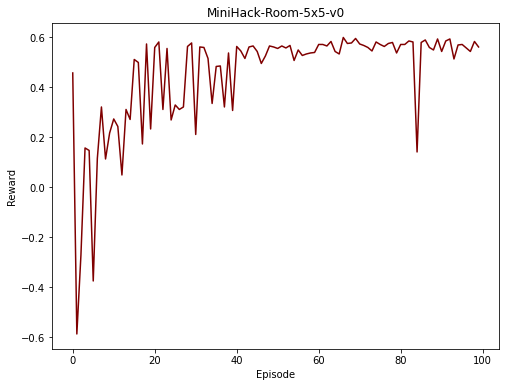

In [30]:
env = gym.make("MiniHack-Room-5x5-v0", observation_keys=["glyphs","pixel","message"],max_episode_steps=1000)
room_rewards = []
state = format_state(env.reset())
seeds = getSeeds(5) #average over 5 runs
for seed in seeds:
  act_critic_model = ActorCritic3(h_size=512, a_size=env.action_space.n)
  policy, model_rewards = run(env=env,model = act_critic_model, seed = seed )
  room_rewards.append(model_rewards)

plot_results("MiniHack-Room-5x5-v0",room_rewards)

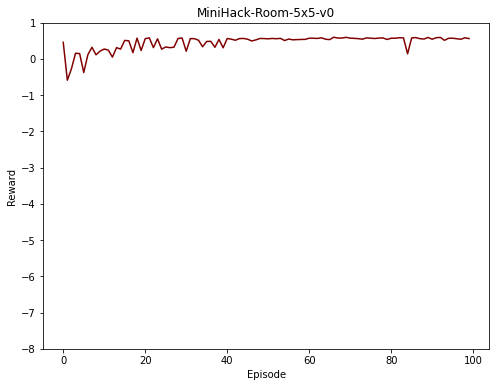

In [43]:
plot_results("MiniHack-Room-5x5-v0",room_rewards)

## Run on MiniHack-Eat-v0

Episode: 0 Reward: -0.8600000000000001 Average Reward: -0.8600000000000001 Steps 250
Episode: 1 Reward: -2.5 Average Reward: -1.6800000000000002 Steps 250
Episode: 2 Reward: 0.57 Average Reward: -0.9300000000000002 Steps 77
Episode: 3 Reward: -0.91 Average Reward: -0.9250000000000002 Steps 250
Episode: 4 Reward: 0.38 Average Reward: -0.6640000000000001 Steps 88
Episode: 5 Reward: -1.8499999999999999 Average Reward: -0.8616666666666668 Steps 250
Episode: 6 Reward: 0.82 Average Reward: -0.6214285714285716 Steps 29
Episode: 7 Reward: 0.85 Average Reward: -0.4375 Steps 26
Episode: 8 Reward: 0.6799999999999999 Average Reward: -0.31333333333333335 Steps 79
Episode: 9 Reward: 0.32999999999999996 Average Reward: -0.24900000000000003 Steps 130
Episode: 10 Reward: -1.1400000000000001 Average Reward: -0.33 Steps 250
Episode: 11 Reward: 0.22999999999999987 Average Reward: -0.2833333333333334 Steps 160
Episode: 12 Reward: -1.09 Average Reward: -0.3453846153846154 Steps 250
Episode: 13 Reward: -1.0 

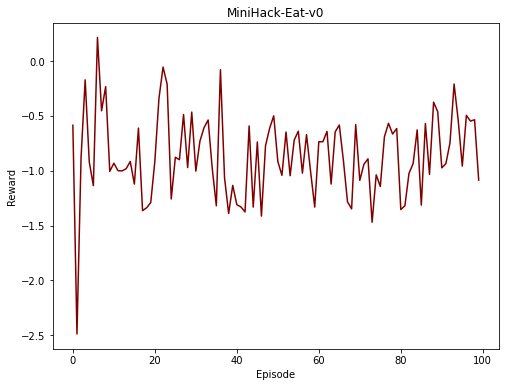

In [31]:
eat_rewards = []
moves = tuple(nethack.CompassDirection)
env = gym.make("MiniHack-Eat-v0", observation_keys=["glyphs","pixel","message"],
               actions = moves + (nethack.Command.EAT,), max_episode_steps=1000)

seeds = getSeeds(5)
for seed in seeds:
  act_critic_model = ActorCritic3(h_size=512, a_size=env.action_space.n)
  policy, model_rewards = run(env=env,model = act_critic_model, seed = seed )
  eat_rewards.append(model_rewards)

plot_results("MiniHack-Eat-v0",eat_rewards)

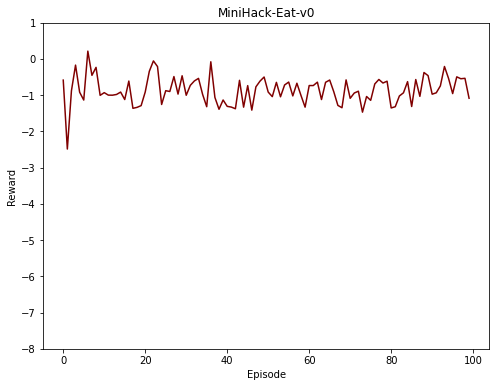

In [44]:
plot_results("MiniHack-Eat-v0",eat_rewards)

## Run on MiniHack-WoD-Easy-v0

Episode: 0 Reward: -0.4800000000000001 Average Reward: -0.4800000000000001 Steps 50
Episode: 1 Reward: -0.5 Average Reward: -0.49000000000000005 Steps 50
Episode: 2 Reward: -0.4900000000000001 Average Reward: -0.49000000000000005 Steps 50
Episode: 3 Reward: -0.07 Average Reward: -0.38500000000000006 Steps 8
Episode: 4 Reward: -0.4900000000000001 Average Reward: -0.406 Steps 50
Episode: 5 Reward: -0.4900000000000001 Average Reward: -0.4200000000000001 Steps 50
Episode: 6 Reward: -0.10999999999999999 Average Reward: -0.3757142857142858 Steps 12
Episode: 7 Reward: -0.4700000000000001 Average Reward: -0.38750000000000007 Steps 50
Episode: 8 Reward: -0.38 Average Reward: -0.3866666666666667 Steps 42
Episode: 9 Reward: -0.5 Average Reward: -0.398 Steps 50
Episode: 10 Reward: -0.4900000000000001 Average Reward: -0.4063636363636364 Steps 50
Episode: 11 Reward: -0.28 Average Reward: -0.3958333333333334 Steps 33
Episode: 12 Reward: -0.4900000000000001 Average Reward: -0.40307692307692317 Steps 5

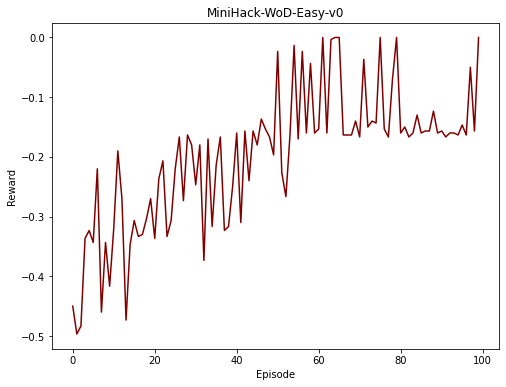

In [27]:
 
env = gym.make("MiniHack-WoD-Easy-v0", observation_keys=["glyphs","pixel","message"],max_episode_steps=1000)
 
WoD_rewards = []

seeds = getSeeds(3)
for seed in seeds:
  act_critic_model = ActorCritic3(h_size=512, a_size=env.action_space.n)
  policy, model_rewards = run(env=env,model = act_critic_model, seed = seed)
  WoD_rewards .append(model_rewards)

plot_results("MiniHack-WoD-Easy-v0",WoD_rewards)

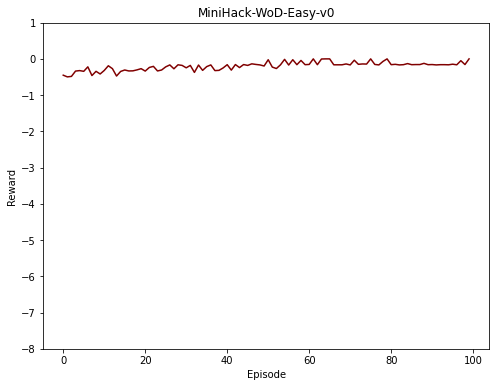

In [45]:
plot_results("MiniHack-WoD-Easy-v0",WoD_rewards)

## Run on MiniHack-Quest-Hard-v0

## Running without reward shaping 

Episode: 0 Reward: -9.46 Average Reward: -9.46 Steps 999
Episode: 1 Reward: -8.469999999999999 Average Reward: -8.965 Steps 999
Episode: 2 Reward: -9.45 Average Reward: -9.126666666666667 Steps 999
Episode: 3 Reward: -5.8 Average Reward: -8.295 Steps 616
Episode: 4 Reward: -3.8899999999999997 Average Reward: -7.414 Steps 409
Episode: 5 Reward: -9.58 Average Reward: -7.7749999999999995 Steps 999
Episode: 6 Reward: -9.59 Average Reward: -8.034285714285714 Steps 994
Episode: 7 Reward: -9.58 Average Reward: -8.2275 Steps 999
Episode: 8 Reward: -9.74 Average Reward: -8.395555555555553 Steps 999
Episode: 9 Reward: -9.61 Average Reward: -8.517 Steps 999
Episode: 10 Reward: -9.989999999999998 Average Reward: -8.650909090909089 Steps 999
Episode: 11 Reward: -9.9 Average Reward: -8.754999999999999 Steps 999
Episode: 12 Reward: -9.469999999999999 Average Reward: -8.809999999999999 Steps 999
Episode: 13 Reward: -5.709999999999999 Average Reward: -8.588571428571427 Steps 585
Episode: 14 Reward: -1.

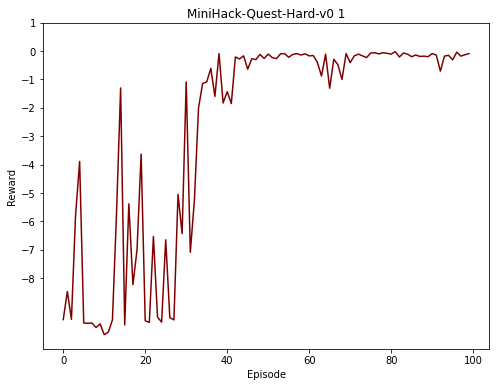

In [12]:
#running without reward shaping 
env = gym.make("MiniHack-Quest-Hard-v0", observation_keys=["glyphs","pixel","message","blstats"])
quest_hard_rewards =[]
seeds = getSeeds(1)
state = format_state(env.reset())
for seed in seeds:
  act_critic_model = ActorCritic3(h_size=512, a_size=env.action_space.n)
  policy, model_rewards = run(env=env,model = act_critic_model, seed = seed )
  quest_hard_rewards.append(model_rewards)

plot_results("MiniHack-Quest-Hard-v0 1",quest_hard_rewards)

## Running with reward shaping 

In [14]:
# Reward Manager for including custom rewards
from minihack import RewardManager

reward_gen = RewardManager()


reward_gen.add_eat_event("apple", reward=1)

reward_gen.add_coordinate_event((11,27), reward = 100, terminal_required = False)# first door at end of maze

#our rewards 
strings = list()
strings.append("What a strange direction!  Never mind.")
reward_gen.add_message_event(strings, reward=-0.01)

reward_gen.add_kill_event("minotaur", reward=1)
strings = list()
strings.append("The door opens.")
reward_gen.add_message_event(strings, reward=1)
######
strings = list()
strings.append("It's solid stone.")
reward_gen.add_message_event(strings, reward=-0.01)

Episode: 0 Reward: -9.530000000000001 Average Reward: -9.530000000000001 Steps 999
Episode: 1 Reward: -9.989999999999998 Average Reward: -9.76 Steps 999
Episode: 2 Reward: -9.52 Average Reward: -9.68 Steps 999
Episode: 3 Reward: -9.49 Average Reward: -9.6325 Steps 999
Episode: 4 Reward: -5.12 Average Reward: -8.73 Steps 539
Episode: 5 Reward: -9.379999999999999 Average Reward: -8.838333333333333 Steps 999
Episode: 6 Reward: -9.44 Average Reward: -8.924285714285714 Steps 999
Episode: 7 Reward: -1.67 Average Reward: -8.0175 Steps 176
Episode: 8 Reward: -9.45 Average Reward: -8.176666666666668 Steps 999
Episode: 9 Reward: -9.43 Average Reward: -8.302000000000001 Steps 999
Episode: 10 Reward: -9.39 Average Reward: -8.400909090909092 Steps 999
Episode: 11 Reward: -9.37 Average Reward: -8.481666666666667 Steps 999
Episode: 12 Reward: -9.54 Average Reward: -8.563076923076924 Steps 999
Episode: 13 Reward: -9.59 Average Reward: -8.636428571428572 Steps 999
Episode: 14 Reward: -7.0 Average Rewar

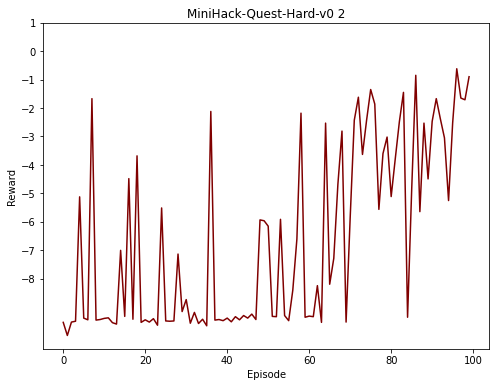

In [15]:
env = gym.make("MiniHack-Quest-Hard-v0", reward_lose = -10, reward_win = 10, reward_manager = reward_gen, observation_keys=["glyphs","pixel","message","blstats"])
quest_hard_rewards =[]
seeds = getSeeds(1)
state = format_state(env.reset())
for seed in seeds:
  act_critic_model = ActorCritic3(h_size=512, a_size=env.action_space.n)
  policy, model_rewards = run(env=env,model = act_critic_model, seed = seed )
  quest_hard_rewards.append(model_rewards)

plot_results("MiniHack-Quest-Hard-v0 2",quest_hard_rewards)

## Running with reward shaping and limited actions 

## Running with reward shaping + movement only 

Episode: 0 Reward: -6.529999999999999 Average Reward: -6.529999999999999 Steps 999
Episode: 1 Reward: -6.17 Average Reward: -6.35 Steps 999
Episode: 2 Reward: -6.319999999999999 Average Reward: -6.34 Steps 999
Episode: 3 Reward: -6.05 Average Reward: -6.2675 Steps 999
Episode: 4 Reward: -6.6 Average Reward: -6.3340000000000005 Steps 999
Episode: 5 Reward: -6.59 Average Reward: -6.376666666666668 Steps 999
Episode: 6 Reward: -6.869999999999999 Average Reward: -6.4471428571428575 Steps 999
Episode: 7 Reward: -6.56 Average Reward: -6.46125 Steps 999
Episode: 8 Reward: -6.539999999999999 Average Reward: -6.47 Steps 999
Episode: 9 Reward: -6.799999999999999 Average Reward: -6.503 Steps 999
Episode: 10 Reward: -6.959999999999999 Average Reward: -6.544545454545454 Steps 999
Episode: 11 Reward: -6.4399999999999995 Average Reward: -6.535833333333333 Steps 999
Episode: 12 Reward: -7.41 Average Reward: -6.603076923076922 Steps 999
Episode: 13 Reward: -6.54 Average Reward: -6.598571428571428 Steps

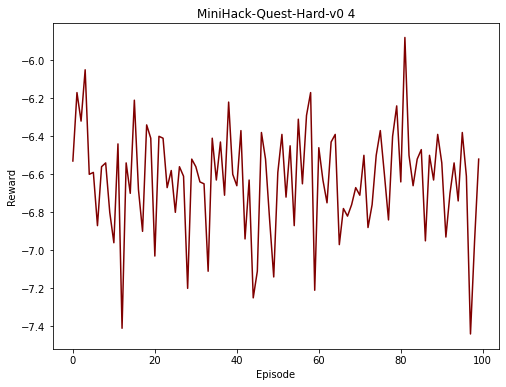

In [ ]:
ACTIONS = tuple(nethack.CompassDirection)

env = gym.make("MiniHack-Quest-Hard-v0", reward_lose = -10, reward_win = 10, reward_manager = reward_gen, observation_keys=["glyphs","pixel","message","blstats"],actions = ACTIONS)
quest_hard_rewards =[]
seeds = getSeeds(1)
state = format_state(env.reset())
for seed in seeds:
  act_critic_model = ActorCritic3(h_size=512, a_size=env.action_space.n)
  policy, model_rewards = run(env=env,model = act_critic_model, seed = seed )
  quest_hard_rewards.append(model_rewards)

plot_results("MiniHack-Quest-Hard-v0 4",quest_hard_rewards)

## Running with blstats + considering visited states using a map 

In [17]:
def format_state_quest(state):
    """
    state dict will now include blstats from observations 
    blstats are not normalized 
    """
  
    glyphs = state["glyphs"]
    glyphs = glyphs/glyphs.max()
    glyphs = glyphs.reshape((1,1,21,79))
    
    
    message = state["message"]
    if state["message"].max()>0: 
        message = message/message.max()
        
    message = message.reshape((1,len(message)))

    # blstats = torch.tensor(state["blstats"],dtype = torch.float)
    blstats = state["blstats"]
    blstats = blstats
    
    state = {"glyphs":glyphs,"message":message, "blstats":blstats}
    return state

In [18]:
class ActorCritic_quest(nn.Module):
    """
    New Actor Critic network that concatenated blstats with glyphs and messages as well
    """
    def __init__(self,s_size=8,h_size=128, a_size=4):

        
        super(ActorCritic_quest, self).__init__()

        self.log_probs = []
        self.rewards = []
        self.state_values  = []

        
        self.conv1 = Conv2d(in_channels=1, out_channels=16, kernel_size=3) #first conv 

       
        self.conv2_fc = Sequential( #2nd conv 
                            ReLU(),
                            MaxPool2d(kernel_size=2, stride=2),

                            
                            Conv2d(in_channels=16, out_channels=32,kernel_size=3),
                            ReLU(),
                            MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),


                            Flatten(),

                            Linear(in_features=1728, out_features=512),
                            ReLU(),

                            Linear(in_features=512, out_features=128),
                            ReLU(),

                          ) 

        self.blstats_fc = Sequential(Linear(in_features=26, out_features=128),
                            ReLU(),)
        self.message_fc = Sequential(
                            Linear(in_features=256, out_features=128),
                            ReLU(),
                          )
        
 
        self.combined_fc = Sequential(
                            Linear(in_features=384, out_features=128),
                            ReLU()
                          )

 
        self.value_layer = Linear(128, 1)

        self.action_layer = Sequential(
                              Linear(128, a_size)
                            )
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, state):
        
 
        glyphs_t  = torch.from_numpy(state["glyphs"]).float().to(device)
        message_t  = torch.from_numpy(state["message"]).float().to(device)
        blstats_t  = torch.from_numpy(state["blstats"]).float().to(device)

        glyphs_t = self.conv2_fc(self.conv1(glyphs_t))

  
        message_t = self.message_fc(message_t)

        blstats_t = self.blstats_fc(blstats_t)
        blstats_t = blstats_t.reshape((1,len(blstats_t)))

        try:
            combined = torch.cat((glyphs_t,message_t,blstats_t),1)
        except:
            combined = torch.concat([glyphs_t,message_t,blstats_t],1)
        
        
        combined = self.combined_fc(combined)

        state_value = self.value_layer(combined)
        
        action_probs = self.action_layer(combined).unsqueeze(0)
        
        action_probs = self.softmax(action_probs)
        

        
        try:
          action_distribution = Categorical(action_probs)
        except: 
          print(glyphs_t)
          print("----------------------")
          print(message_t)
          action_distribution = Categorical(action_probs)
        # select action
        action = action_distribution.sample()

        self.log_probs.append(action_distribution.log_prob(action))
        self.state_values.append(state_value)
        return action.item()
      
    
    def calculateLoss(self, gamma, returns):
    
        loss = 0
        for logprob, value, reward in zip(self.log_probs, self.state_values, returns):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        return loss

    def reset(self):
        del self.log_probs[:]
        del self.state_values[:]
        del self.rewards[:]


In [19]:
def exploring(visited_matrix, curr_pos):
    min_val = 1000
    min_pos = [-1000, -1000]
    states = 2 

    for i in range(states):
        for j in range(states):
            curr = [curr_pos[0], curr_pos[1]]

            if j == 0:
              curr[i] = curr[i]-1

            else:
              curr[i] = curr[i]+1

            if curr[0] < 0 or curr[1] < 0 or curr[0] >= 21 or curr[1] >= 79:
                continue

            curr_val = visited_matrix[curr[0]][curr[1]]

            if curr_val == 1000 or curr_val > 1000: #unvisited 
              continue 

            elif curr_val < min_val: 
                min_val = curr_val
                min_pos = curr


    return min_pos

In [28]:
def run_quest(env, model, seed):

    learning_rate = 0.02
    num_episodes = 100
    max_episodes = 1000
    gamma = 0 #changes based on kind of run 
    # Setting random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    env.seed(seed)
    
    # Initialize optimizer for Actor Critic Network
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # List to store the rewards attained in each episode 
    model_rewards =[]

    state = format_state_quest(env.reset())

    

    visited_states_map = np.full((21,79),1000.0) #will keep count for states in environment 
    visited_states_map[state['blstats'][1]][state["blstats"][0]] = 0
    
    for i in range(num_episodes):
        # Reset environment
        state = format_state_quest(env.reset())
        # Flag to see if episode has terminated
        done = False
 
        
        for t in range(1, max_episodes):
            #COOKED
            # recent_visit_cell =format_observations(state,visited_states_map)
            recent_visit_cell = exploring(visited_states_map, (state['blstats'][1], state['blstats'][0]))

            action = model.forward(state)
            
            # Take selected action, observe the reward received, the next state 
            # and whether or not the episode terminated 
            next_state, reward, done, _ = env.step(action)
            next_state = format_state_quest(next_state)


            if visited_states_map[state['blstats'][1]][next_state['blstats'][0]] >= 1000.0:
                reward = 1.0
            #if agent visited cell it most recently visited then give negative reward
            elif next_state['blstats'][1] == recent_visit_cell[0] and next_state['blstats'][0] == recent_visit_cell[1]:
                reward = -0.2

            if next_state['blstats'][0] == 27 and next_state['blstats'][1] == 11:
                
                reward += 100 

            visited_states_map = visited_states_map + 1.0
            visited_states_map[state['blstats'][1]][state["blstats"][0]] = 0
                
            
            # COOKED
            # Store the reward
            model.rewards.append(reward)
            
            state = next_state
            
            if done:
              visited_states_map = np.full((21,79),1000.0) #will keep count for states in environment 
              visited_states_map[state['blstats'][1]][state["blstats"][0]] = 0

              break
        
        # Store the reward acquired in the episode and calculate the discounted return of the episode
        model_rewards.append(np.sum(model.rewards))
        returns = compute_returns(model.rewards, gamma)
        returns = torch.from_numpy(returns).float().to(device)
        
        # Print the episode, the reward acquired in the episode and the mean reward over the last 50 episodes 
        
        print("Episode:",i,"Reward:",np.sum(model.rewards),"Average Reward:",np.mean(model_rewards[-50:]),"Steps",t)
        
        # COOKED 
        loss = model.calculateLoss(gamma, returns)   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        model.reset()

    # Store the policy as the neural network model at the final iteration 
    policy = model

    return policy, model_rewards

Episode: 0 Reward: 1.1399999999999997 Average Reward: 1.1399999999999997 Steps 614
Episode: 1 Reward: -8.98 Average Reward: -3.9200000000000004 Steps 999
Episode: 2 Reward: -2.7800000000000007 Average Reward: -3.5400000000000005 Steps 999
Episode: 3 Reward: -6.07 Average Reward: -4.1725 Steps 999
Episode: 4 Reward: -1.6800000000000006 Average Reward: -3.6740000000000004 Steps 999
Episode: 5 Reward: -1.85 Average Reward: -3.3700000000000006 Steps 999
Episode: 6 Reward: -1.19 Average Reward: -3.058571428571429 Steps 999
Episode: 7 Reward: -6.15 Average Reward: -3.4450000000000003 Steps 999
Episode: 8 Reward: -5.67 Average Reward: -3.6922222222222225 Steps 999
Episode: 9 Reward: -2.05 Average Reward: -3.528 Steps 999
Episode: 10 Reward: -2.6400000000000006 Average Reward: -3.4472727272727273 Steps 999
Episode: 11 Reward: 1.3100000000000005 Average Reward: -3.0508333333333333 Steps 999
Episode: 12 Reward: 3.7499999999999996 Average Reward: -2.5276923076923077 Steps 999
Episode: 13 Reward: 

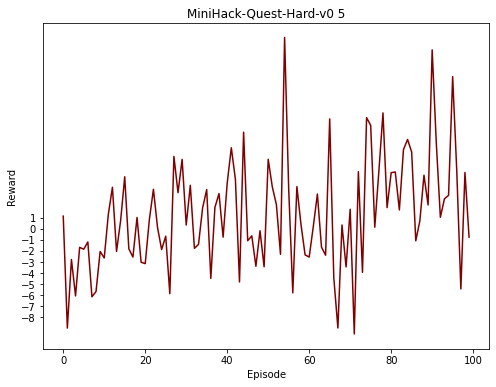

In [25]:
env = gym.make("MiniHack-Quest-Hard-v0", reward_lose = -10, reward_win = 10, reward_manager = reward_gen, observation_keys=["glyphs","pixel","message","blstats"], savedir = "./games2/")
quest_hard_rewards =[]
seeds = getSeeds(1)
state = format_state(env.reset())

for seed in seeds:
  act_critic_model = ActorCritic_quest(h_size=512, a_size=env.action_space.n)
  policy, model_rewards = run_quest(env=env,model = act_critic_model, seed = seed )
  quest_hard_rewards.append(model_rewards)

plot_results("MiniHack-Quest-Hard-v0 5",quest_hard_rewards)

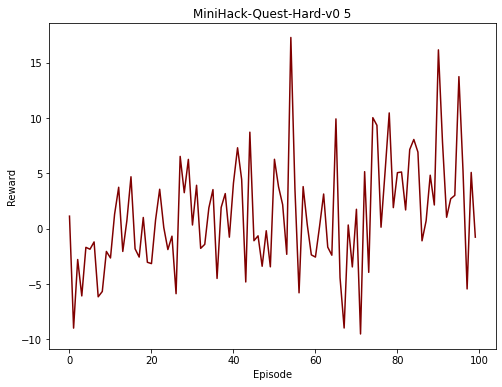

In [27]:
plot_results("MiniHack-Quest-Hard-v0 5",quest_hard_rewards)

Episode: 0 Reward: -2.250000000000001 Average Reward: -2.250000000000001 Steps 999
Episode: 1 Reward: -7.97 Average Reward: -5.11 Steps 999
Episode: 2 Reward: 0.9599999999999991 Average Reward: -3.0866666666666673 Steps 999
Episode: 3 Reward: 2.059999999999999 Average Reward: -1.8000000000000007 Steps 999
Episode: 4 Reward: -8.34 Average Reward: -3.1080000000000005 Steps 999
Episode: 5 Reward: -6.05 Average Reward: -3.598333333333334 Steps 999
Episode: 6 Reward: 0.0999999999999992 Average Reward: -3.0700000000000007 Steps 999
Episode: 7 Reward: 11.089999999999998 Average Reward: -1.3000000000000007 Steps 999
Episode: 8 Reward: 15.0 Average Reward: 0.5111111111111105 Steps 999
Episode: 9 Reward: -0.6000000000000008 Average Reward: 0.39999999999999936 Steps 999
Episode: 10 Reward: 7.719999999999999 Average Reward: 1.0654545454545448 Steps 999
Episode: 11 Reward: -2.29 Average Reward: 0.7858333333333327 Steps 999
Episode: 12 Reward: 6.459999999999999 Average Reward: 1.2223076923076917 Ste

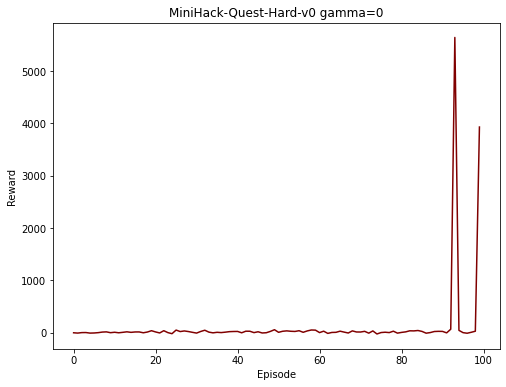

In [29]:
env = gym.make("MiniHack-Quest-Hard-v0", reward_lose = -10, reward_win = 10, reward_manager = reward_gen, observation_keys=["glyphs","pixel","message","blstats"], savedir = "./games2/")
quest_hard_rewards =[]
seeds = getSeeds(1)
state = format_state(env.reset())

for seed in seeds:
  act_critic_model = ActorCritic_quest(h_size=512, a_size=env.action_space.n)
  policy, model_rewards = run_quest(env=env,model = act_critic_model, seed = seed )
  quest_hard_rewards.append(model_rewards)

plot_results("MiniHack-Quest-Hard-v0 gamma=0",quest_hard_rewards)

## Movement actions 

In [33]:
moves = tuple(nethack.CompassDirection)
ACTIONS = moves + ( 
    nethack.CompassDirection.NW,
    nethack.Command.PICKUP,
    nethack.Command.EAT,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP, 
    nethack.Command.PUTON,
    nethack.Command.AUTOPICKUP,
    nethack.Command.OPEN,
    nethack.Command.KICK,
    nethack.Command.READ,
    nethack.Command.SEARCH,
    nethack.Command.WEAR,
    nethack.Command.WIELD,
    nethack.Command.QUAFF
)

env = gym.make("MiniHack-Quest-Hard-v0", reward_lose = -10, reward_win = 10, reward_manager = reward_gen, observation_keys=["glyphs","pixel","message","blstats"],actions = ACTIONS)



In [ ]:
quest_hard_rewards =[]
seeds = getSeeds(1)
state = format_state(env.reset())
for seed in seeds:
  act_critic_model = ActorCritic_quest(h_size=512, a_size=env.action_space.n)
  policy, model_rewards = run_quest(env=env,model = act_critic_model, seed = seed )
  quest_hard_rewards.append(model_rewards)

plot_results("MiniHack-Quest-Hard-v0 limited actions",quest_hard_rewards)

Episode: 0 Reward: 10.689999999999998 Average Reward: 10.689999999999998 Steps 999
Episode: 1 Reward: -8.989999999999998 Average Reward: 0.8499999999999996 Steps 999
Episode: 2 Reward: 0.5099999999999962 Average Reward: 0.7366666666666651 Steps 999
Episode: 3 Reward: -6.830000000000001 Average Reward: -1.1550000000000014 Steps 999
Episode: 4 Reward: 2.59 Average Reward: -0.40600000000000114 Steps 338
Episode: 5 Reward: -6.92 Average Reward: -1.4916666666666678 Steps 999
Episode: 6 Reward: -10.55 Average Reward: -2.785714285714287 Steps 999
Episode: 7 Reward: 0.28999999999999915 Average Reward: -2.401250000000001 Steps 999
Episode: 8 Reward: -3.280000000000001 Average Reward: -2.49888888888889 Steps 999
Episode: 9 Reward: 7.029999999999998 Average Reward: -1.5460000000000012 Steps 999
Episode: 10 Reward: -1.7700000000000018 Average Reward: -1.5663636363636377 Steps 999
Episode: 11 Reward: 2.0099999999999985 Average Reward: -1.2683333333333346 Steps 999
Episode: 12 Reward: -9.22000000000

# Final Run